# GTI-4-GDP - Part 1-of-2
# Part 1 = Google Trends Index (GTI) Pipeline (this notebook)
# GTI generated (as xlsx,) from (this notebook) used as input 1-of-16 to:
# Part 2-of-2, Part 2 = 16 time-series input to create GDP NowCast Forecast
# Objective: Forecast quarterly U.S. GDP before the official-release.   

## Executive Summary

Both notebooks implement a comprehensive pipeline for generating quarterly
economic sentiment index derived from 16 time-series, of which this notebook is 1 of those time-series: Google Trends search data. The GTI serves as a leading indicator capturing consumer sentiment through search behavior patterns. The user can use our own proprietary-list of 200 terms, or, create their own list via csv, or text-input (options at bottom of this notebook.)

## Pipeline Workflow

1. **Data Acquisition**: Fetch Google Trends data for 200 economic terms (this notebook,) (and then everything else is in notebook2 (Part 2-of-2)
2. **Temporal Aggregation**: Convert weekly data to quarterly frequency
3. **Quality Filtering**: Remove sparse or low-signal time series
4. **Dimensionality Reduction**: Apply PCA to extract primary component
5. **Normalization**: Scale GTI to 0-100 range for interpretability
6. **Export**: Save quarterly GTI index to Excel format

## Data Specification

- **Temporal Coverage**: 2004-01-01 through present (quarterly)
- **Geographic Scope**: United States (geo='US')
- **Term Categories**: 100 pessimistic + 100 optimistic indicators // (c) ai70000, Ltd.
- **Output Format**: Excel (.xlsx) with date and GTI columns

## Intellectual Property

The 200-term list (not GTI itself,)
is proprietary to ai70000, Ltd.


In [ ]:
"""Environment setup and dependency installation.

This cell installs required packages and imports all dependencies needed
for the GTI pipeline execution.
"""

# Install pytrends library for Google Trends API access.
!pip install -q pytrends openpyxl

# Standard library imports.
import datetime as dt
import time
from typing import List, Optional, Tuple

# Third-party imports.
import numpy as np
import pandas as pd
from pytrends.request import TrendReq
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Suppress pandas warnings for cleaner output.
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

print("Environment setup complete.")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")


Environment setup complete.
Pandas version: 2.2.2
NumPy version: 2.0.2


In [ ]:
"""Configuration constants for GTI pipeline.

This cell defines all configuration parameters used throughout the pipeline.
Centralizing these values enables easy adjustment of pipeline behavior.
"""

# Temporal parameters.
START_DATE = "2004-01-01"
END_DATE = dt.date.today().isoformat()
TIMEFRAME = f"{START_DATE} {END_DATE}"

# API request parameters.
MAX_RETRIES = 5
SLEEP_BETWEEN_BATCHES = 3
GEO_REGION = 'US'

# Data quality parameters.
SPARSITY_THRESHOLD = 0.20
MIN_VALID_RATIO = 0.5

# Output formatting parameters.
DECIMALS = 2
OUTPUT_MIN = 0.0
OUTPUT_MAX = 100.0

print("Configuration loaded:")
print(f"  Date range: {START_DATE} to {END_DATE}")
print(f"  Geographic region: {GEO_REGION}")
print(f"  Sparsity threshold: {SPARSITY_THRESHOLD}")
print(f"  Output scale: {OUTPUT_MIN}-{OUTPUT_MAX}")


Configuration loaded:
  Date range: 2004-01-01 to 2025-12-25
  Geographic region: US
  Sparsity threshold: 0.2
  Output scale: 0.0-100.0


In [ ]:
"""Master term list for Google Trends queries.

This cell defines the 200 economic search terms used to construct the GTI.
Terms are categorized into pessimistic (1-100) and optimistic (101-200)
indicators to capture bidirectional economic sentiment.

The list structure is proprietary to ai70000, Ltd.
"""

# Economic sentiment search terms.
GTI_TERMS = [
    # Pessimistic indicators: Economic distress and financial hardship.
    "job search help",
    "jobless claims",
    "how to file for unemployment",
    "food stamps application",
    "quick cash loans",
    "debt relief programs",
    "housing assistance",
    "eviction notice",
    "bankruptcy attorney",
    "how to cancel credit card",
    "cheap groceries near me",
    "used cars under $5000",
    "buy now pay later",
    "coupon code",
    "free food near me",
    "thrift stores",
    "meal prepping on a budget",
    "refinance my loan",
    "save money fast",
    "how to negotiate rent",
    "layoffs this week",
    "remote jobs hiring now",
    "small business loan forgiveness",
    "work from home jobs",
    "how to start a side hustle",
    "part time job near me",
    "business closing near me",
    "SBA loan application",
    "commercial real estate vacancy",
    "warehouse jobs",
    "market crash",
    "is a recession coming",
    "recession 2025",
    "GDP definition",
    "inflation vs deflation",
    "stagflation",
    "stock market bubble",
    "housing bubble",
    "interest rates today",
    "credit problems",
    "401k withdrawal penalty",
    "student loan forgiveness update",
    "late credit card payment",
    "auto loan default",
    "how to consolidate debt",
    "debt ceiling crisis",
    "bank run",
    "credit freeze",
    "evictions 2025",
    "payday advance apps",
    "mortgage relief program",
    "housing assistance application",
    "section 8 waiting list",
    "affordable housing lottery",
    "moving back with parents",
    "rent freeze extension",
    "rent control map",
    "housing crisis",
    "mortgage forbearance 2024",
    "eviction moratorium",
    "cancel gym membership",
    "free wifi near me",
    "low income cell phone plans",
    "food bank locations",
    "ebt balance check",
    "snap benefits",
    "secondhand furniture near me",
    "diy home repair",
    "budget travel tips",
    "how to sell stuff online",
    "deliver groceries for money",
    "gig work near me",
    "temp agency jobs",
    "apply for Uber driver",
    "amazon warehouse hiring",
    "resume builder free",
    "get paid to take surveys",
    "jobs without degree",
    "unemployment extension",
    "resume gap explanation",
    "dow jones crash",
    "fed interest rate hike",
    "inflation calculator",
    "treasury yield curve inversion",
    "deflation meaning",
    "economic collapse",
    "u.s. debt clock",
    "inflation hedge stocks",
    "stimulus check update",
    "jobless rate",
    "panic buying",
    "sell stocks now",
    "gold price prediction",
    "buy crypto now",
    "bitcoin crash",
    "best states to move during recession",
    "cheap rent states",
    "lowest cost of living",
    "should I rent or buy",
    "when will the recession end",
    # Optimistic indicators: Economic confidence and growth.
    "promotion at work",
    "salary negotiation",
    "job offer negotiation",
    "professional development courses",
    "best companies to work for",
    "remote job opportunities",
    "relocate for job",
    "high paying careers",
    "leadership training",
    "executive mba",
    "buy a house",
    "home mortgage approval",
    "best cities to buy a home",
    "real estate investing",
    "moving to suburbs",
    "new home construction",
    "refinance to renovate",
    "luxury homes near me",
    "home improvement loans",
    "smart home upgrades",
    "buy new car",
    "car dealership near me",
    "best SUV 2024",
    "electric vehicles",
    "car loan preapproval",
    "luxury car brands",
    "auto lease deals",
    "trade in my car",
    "car insurance discounts",
    "best hybrid cars",
    "online shopping deals",
    "home decor trends",
    "best credit card rewards",
    "designer clothing sale",
    "smart tv deals",
    "kitchen remodel ideas",
    "upgrade phone",
    "vacation packages 2025",
    "new iPhone release",
    "shopping malls near me",
    "invest in stocks",
    "roth ira vs 401k",
    "how to buy etfs",
    "open a brokerage account",
    "dividend stocks 2025",
    "invest in real estate",
    "nasdaq rally",
    "best index funds",
    "personal finance tips",
    "dollar cost averaging",
    "cheap flights to europe",
    "cruise deals 2025",
    "honeymoon destinations",
    "best beach resorts",
    "travel insurance comparison",
    "luxury vacation rentals",
    "national parks trips",
    "all inclusive resorts",
    "ski vacation deals",
    "international travel checklist",
    "online mba programs",
    "apply for college",
    "study abroad scholarships",
    "graduate school deadlines",
    "best coding bootcamps",
    "continuing education online",
    "get a certificate in data science",
    "upskill with ai",
    "language learning apps",
    "online master's programs",
    "increase credit score",
    "refinance to lower rate",
    "open high yield savings account",
    "credit card cash back",
    "bank interest rates up",
    "mortgage refinancing",
    "home equity loan",
    "personal loan offers",
    "budget planner apps",
    "best banks to save money",
    "fitness programs near me",
    "new gym membership",
    "meditation retreat",
    "healthy meal delivery",
    "wellness travel",
    "dental implants",
    "elective surgery",
    "yoga classes near me",
    "therapy near me",
    "self improvement goals",
    "move to a better city",
    "best states for jobs",
    "where to start a business",
    "relocate for lower taxes",
    "affordable cities with good schools",
    "coworking spaces near me",
    "housing market forecast",
    "cost of living comparison",
    "new apartment listings",
    "downtown redevelopment",
]

# Remove duplicates while preserving order.
GTI_TERMS = list(dict.fromkeys(GTI_TERMS))

# Anchor terms for cross-batch normalization.
ANCHOR_TERMS = [
    "unemployment benefits",
    "payday loan near me",
    "rent assistance",
    "credit card default rate",
]

print(f"Master term list loaded: {len(GTI_TERMS)} unique terms")
print(f"Anchor terms: {len(ANCHOR_TERMS)} terms for cross-batch scaling")


Master term list loaded: 200 unique terms
Anchor terms: 4 terms for cross-batch scaling


In [ ]:
"""Custom GTI Terms Selection - Clean Simple Layout.

This cell provides three options for defining the 200 Google Trends search terms.
"""

import io
from typing import List, Optional

import ipywidgets as widgets
import pandas as pd
from IPython.display import clear_output, display


# Default 200-term list (proprietary structure to ai70000, Ltd.).
DEFAULT_GTI_TERMS = [
    # Pessimistic indicators (1-100).
    "job search help",
    "jobless claims",
    "how to file for unemployment",
    "food stamps application",
    "quick cash loans",
    "debt relief programs",
    "housing assistance",
    "eviction notice",
    "bankruptcy attorney",
    "how to cancel credit card",
    "cheap groceries near me",
    "used cars under $5000",
    "buy now pay later",
    "coupon code",
    "free food near me",
    "thrift stores",
    "meal prepping on a budget",
    "refinance my loan",
    "save money fast",
    "how to negotiate rent",
    "layoffs this week",
    "remote jobs hiring now",
    "small business loan forgiveness",
    "work from home jobs",
    "how to start a side hustle",
    "part time job near me",
    "business closing near me",
    "SBA loan application",
    "commercial real estate vacancy",
    "warehouse jobs",
    "market crash",
    "is a recession coming",
    "recession 2025",
    "GDP definition",
    "inflation vs deflation",
    "stagflation",
    "stock market bubble",
    "housing bubble",
    "interest rates today",
    "credit problems",
    "401k withdrawal penalty",
    "student loan forgiveness update",
    "late credit card payment",
    "auto loan default",
    "how to consolidate debt",
    "debt ceiling crisis",
    "bank run",
    "credit freeze",
    "evictions 2025",
    "payday advance apps",
    "mortgage relief program",
    "housing assistance application",
    "section 8 waiting list",
    "affordable housing lottery",
    "moving back with parents",
    "rent freeze extension",
    "rent control map",
    "housing crisis",
    "mortgage forbearance 2024",
    "eviction moratorium",
    "cancel gym membership",
    "free wifi near me",
    "low income cell phone plans",
    "food bank locations",
    "ebt balance check",
    "snap benefits",
    "secondhand furniture near me",
    "diy home repair",
    "budget travel tips",
    "how to sell stuff online",
    "deliver groceries for money",
    "gig work near me",
    "temp agency jobs",
    "apply for Uber driver",
    "amazon warehouse hiring",
    "resume builder free",
    "get paid to take surveys",
    "jobs without degree",
    "unemployment extension",
    "resume gap explanation",
    "dow jones crash",
    "fed interest rate hike",
    "inflation calculator",
    "treasury yield curve inversion",
    "deflation meaning",
    "economic collapse",
    "u.s. debt clock",
    "inflation hedge stocks",
    "stimulus check update",
    "jobless rate",
    "panic buying",
    "sell stocks now",
    "gold price prediction",
    "buy crypto now",
    "bitcoin crash",
    "best states to move during recession",
    "cheap rent states",
    "lowest cost of living",
    "should I rent or buy",
    "when will the recession end",
    # Optimistic indicators (101-200).
    "promotion at work",
    "salary negotiation",
    "job offer negotiation",
    "professional development courses",
    "best companies to work for",
    "remote job opportunities",
    "relocate for job",
    "high paying careers",
    "leadership training",
    "executive mba",
    "buy a house",
    "home mortgage approval",
    "best cities to buy a home",
    "real estate investing",
    "moving to suburbs",
    "new home construction",
    "refinance to renovate",
    "luxury homes near me",
    "home improvement loans",
    "smart home upgrades",
    "buy new car",
    "car dealership near me",
    "best SUV 2024",
    "electric vehicles",
    "car loan preapproval",
    "luxury car brands",
    "auto lease deals",
    "trade in my car",
    "car insurance discounts",
    "best hybrid cars",
    "online shopping deals",
    "home decor trends",
    "best credit card rewards",
    "designer clothing sale",
    "smart tv deals",
    "kitchen remodel ideas",
    "upgrade phone",
    "vacation packages 2025",
    "new iPhone release",
    "shopping malls near me",
    "invest in stocks",
    "roth ira vs 401k",
    "how to buy etfs",
    "open a brokerage account",
    "dividend stocks 2025",
    "invest in real estate",
    "nasdaq rally",
    "best index funds",
    "personal finance tips",
    "dollar cost averaging",
    "cheap flights to europe",
    "cruise deals 2025",
    "honeymoon destinations",
    "best beach resorts",
    "travel insurance comparison",
    "luxury vacation rentals",
    "national parks trips",
    "all inclusive resorts",
    "ski vacation deals",
    "international travel checklist",
    "online mba programs",
    "apply for college",
    "study abroad scholarships",
    "graduate school deadlines",
    "best coding bootcamps",
    "continuing education online",
    "get a certificate in data science",
    "upskill with ai",
    "language learning apps",
    "online master's programs",
    "increase credit score",
    "refinance to lower rate",
    "open high yield savings account",
    "credit card cash back",
    "bank interest rates up",
    "mortgage refinancing",
    "home equity loan",
    "personal loan offers",
    "budget planner apps",
    "best banks to save money",
    "fitness programs near me",
    "new gym membership",
    "meditation retreat",
    "healthy meal delivery",
    "wellness travel",
    "dental implants",
    "elective surgery",
    "yoga classes near me",
    "therapy near me",
    "self improvement goals",
    "move to a better city",
    "best states for jobs",
    "where to start a business",
    "relocate for lower taxes",
    "affordable cities with good schools",
    "coworking spaces near me",
    "housing market forecast",
    "cost of living comparison",
    "new apartment listings",
    "downtown redevelopment",
]


# Module-level variable to store selected terms.
GTI_TERMS: List[str] = []


def validate_terms(terms: List[str]) -> tuple[bool, str]:
    """Validate GTI search terms list.

    Args:
        terms: List of search terms to validate.

    Returns:
        Tuple of (is_valid, message).
    """
    if not terms:
        return False, "Error: Term list is empty."

    if not all(isinstance(term, str) for term in terms):
        return False, "Error: All terms must be strings."

    unique_terms = list(dict.fromkeys(terms))
    if len(unique_terms) != len(terms):
        removed = len(terms) - len(unique_terms)
        return False, f"Warning: {removed} duplicate terms removed."

    if len(unique_terms) < 10:
        return False, "Error: Need at least 10 terms."

    if len(unique_terms) > 500:
        return False, "Warning: 500+ terms may be slow."

    return True, f"Success: {len(unique_terms)} terms validated."


def parse_csv_terms(file_content: bytes) -> Optional[List[str]]:
    """Parse terms from CSV file.

    Args:
        file_content: CSV file bytes.

    Returns:
        List of terms or None if failed.
    """
    try:
        df = pd.read_csv(io.BytesIO(file_content))

        if len(df.columns) == 1:
            terms = df.iloc[:, 0].dropna().astype(str).str.strip().tolist()
        elif 'term' in df.columns:
            terms = df['term'].dropna().astype(str).str.strip().tolist()
        elif 'search_term' in df.columns:
            terms = df['search_term'].dropna().astype(str).str.strip().tolist()
        else:
            return None

        return [t for t in terms if t]
    except Exception:
        return None


def parse_text_terms(text: str) -> List[str]:
    """Parse terms from text.

    Args:
        text: Multi-line or comma-separated text.

    Returns:
        List of parsed terms.
    """
    lines = text.split('\n')
    terms = []
    for line in lines:
        if ',' in line:
            terms.extend(line.split(','))
        else:
            terms.append(line)

    return [t.strip() for t in terms if t.strip()]


def create_terms_selector() -> None:
    """Create interactive GTI terms selector."""
    global GTI_TERMS

    # Buttons for selection.
    btn_default = widgets.Button(
        description='Default 200 Terms',
        button_style='info',
        layout=widgets.Layout(width='200px')
    )

    btn_csv = widgets.Button(
        description='Upload CSV File',
        button_style='',
        layout=widgets.Layout(width='200px')
    )

    btn_text = widgets.Button(
        description='Paste Terms',
        button_style='',
        layout=widgets.Layout(width='200px')
    )

    # Dynamic content area.
    content_area = widgets.VBox([])

    # Output area.
    output_area = widgets.Output()

    def show_default(b: widgets.Button) -> None:
        """Show default option.

        Args:
            b: Button widget.
        """
        btn_default.button_style = 'info'
        btn_csv.button_style = ''
        btn_text.button_style = ''

        content_area.children = [
            widgets.HTML(
                "<p>Using proven 200-term list (100 pessimistic + "
                "100 optimistic indicators).</p>"
                "<p>Click 'Confirm' below to proceed.</p>"
            )
        ]

    def show_csv(b: widgets.Button) -> None:
        """Show CSV upload option.

        Args:
            b: Button widget.
        """
        btn_default.button_style = ''
        btn_csv.button_style = 'info'
        btn_text.button_style = ''

        uploader = widgets.FileUpload(
            accept='.csv',
            multiple=False,
            description='Select CSV:',
            layout=widgets.Layout(width='400px')
        )

        content_area.children = [
            widgets.HTML(
                "<p>Upload a CSV file with one column containing search terms.</p>"
                "<p>Expected format: 'term' column header (or no header).</p>"
            ),
            uploader
        ]
        content_area._csv_widget = uploader

    def show_text(b: widgets.Button) -> None:
        """Show text input option.

        Args:
            b: Button widget.
        """
        btn_default.button_style = ''
        btn_csv.button_style = ''
        btn_text.button_style = 'info'

        text_box = widgets.Textarea(
            placeholder='Enter terms (one per line or comma-separated)',
            layout=widgets.Layout(width='600px', height='200px')
        )

        content_area.children = [
            widgets.HTML("<p>Enter your custom search terms below:</p>"),
            text_box
        ]
        content_area._text_widget = text_box

    def on_confirm(b: widgets.Button) -> None:
        """Handle confirm action.

        Args:
            b: Button widget.
        """
        global GTI_TERMS

        with output_area:
            clear_output()

            if btn_default.button_style == 'info':
                GTI_TERMS = DEFAULT_GTI_TERMS.copy()
                print(f"Selected: Default terms ({len(GTI_TERMS)} total)")
                print("\nFirst 5 terms:")
                for i, term in enumerate(GTI_TERMS[:5], 1):
                    print(f"  {i}. {term}")
                print("...")
                print("\nReady to proceed with GTI pipeline.")

            elif btn_csv.button_style == 'info':
                if not hasattr(content_area, '_csv_widget'):
                    print("Error: CSV widget not found.")
                    return

                csv_widget = content_area._csv_widget
                if not csv_widget.value:
                    print("Error: Please upload a CSV file.")
                    return

                uploaded = list(csv_widget.value.values())[0]
                terms = parse_csv_terms(uploaded['content'])

                if terms is None:
                    print("Error: Could not parse CSV.")
                    print("Expected: Single column with 'term' header")
                    return

                is_valid, message = validate_terms(terms)
                print(message)

                if is_valid:
                    GTI_TERMS = list(dict.fromkeys(terms))
                    print(f"\nLoaded {len(GTI_TERMS)} terms")
                    print("\nFirst 5 terms:")
                    for i, term in enumerate(GTI_TERMS[:5], 1):
                        print(f"  {i}. {term}")
                    print("...")
                    print("\nReady to proceed with GTI pipeline.")

            elif btn_text.button_style == 'info':
                if not hasattr(content_area, '_text_widget'):
                    print("Error: Text widget not found.")
                    return

                text_widget = content_area._text_widget
                text = text_widget.value.strip()

                if not text:
                    print("Error: Please enter search terms.")
                    return

                terms = parse_text_terms(text)
                is_valid, message = validate_terms(terms)
                print(message)

                if is_valid:
                    GTI_TERMS = list(dict.fromkeys(terms))
                    print(f"\nParsed {len(GTI_TERMS)} terms")
                    print("\nFirst 5 terms:")
                    for i, term in enumerate(GTI_TERMS[:5], 1):
                        print(f"  {i}. {term}")
                    print("...")
                    print("\nReady to proceed with GTI pipeline.")

    # Attach handlers.
    btn_default.on_click(show_default)
    btn_csv.on_click(show_csv)
    btn_text.on_click(show_text)

    # Confirm button.
    btn_confirm = widgets.Button(
        description='Confirm Selection',
        button_style='success',
        icon='check',
        layout=widgets.Layout(width='200px')
    )
    btn_confirm.on_click(on_confirm)

    # Initialize with default.
    show_default(None)

    # Display interface.
    display(widgets.VBox([
        widgets.HTML("<h3>GTI Search Terms Configuration</h3>"),
        widgets.HTML("<p>Select your input method:</p>"),
        widgets.HBox([btn_default, btn_csv, btn_text]),
        widgets.HTML("<hr>"),
        content_area,
        widgets.HTML("<br>"),
        btn_confirm,
        widgets.HTML("<hr>"),
        output_area
    ]))


# Create selector.
print("=" * 70)
print("CUSTOM GTI TERMS SELECTION")
print("=" * 70)
print("")
create_terms_selector()

CUSTOM GTI TERMS SELECTION



In [ ]:
"""Core utility functions for GTI pipeline.

This cell defines all helper functions used in data acquisition,
preprocessing, and transformation stages of the pipeline.
"""


def create_batches(
    terms: List[str],
    anchors: List[str],
    batch_size: int = 4,
) -> List[List[str]]:
    """Create batches of search terms with rotating anchor terms.

    Google Trends API enforces a maximum of 5 terms per request. This
    function creates batches of 4 primary terms plus 1 rotating anchor
    term to enable cross-batch comparability while respecting API limits.

    The anchor terms provide reference points for relative scaling across
    batches since Google Trends normalizes each request independently.

    Args:
        terms: Complete list of search terms to batch.
        anchors: List of anchor terms for rotation across batches.
        batch_size: Number of primary terms per batch (default: 4).

    Returns:
        List of batches, each containing batch_size+1 terms total.
    """
    batches = []
    for i in range(0, len(terms), batch_size):
        group = terms[i:i + batch_size]
        anchor = anchors[(i // batch_size) % len(anchors)]
        batch = [anchor] + group
        batches.append(batch)
    return batches


def fetch_batch(
    pytrends: TrendReq,
    terms: List[str],
    timeframe: str,
    geo: str = GEO_REGION,
    max_retries: int = MAX_RETRIES,
) -> pd.DataFrame:
    """Fetch Google Trends data with exponential backoff retry logic.

    Implements robust error handling for API rate limiting and transient
    network failures. Uses exponential backoff (5s, 10s, 15s, etc.) to
    avoid overwhelming the API while maximizing successful fetches.

    Args:
        pytrends: Initialized TrendReq API client object.
        terms: List of search terms for this batch (max 5).
        timeframe: ISO date range string (e.g., '2004-01-01 2024-12-24').
        geo: Two-letter country code (default: US).
        max_retries: Maximum retry attempts on failure (default: 5).

    Returns:
        DataFrame with DatetimeIndex and term columns containing 0-100
        normalized search interest values. Returns empty DataFrame if
        all retry attempts fail.
    """
    retries = 0
    while retries < max_retries:
        try:
            pytrends.build_payload(terms, timeframe=timeframe, geo=geo)
            df = pytrends.interest_over_time()

            # Remove metadata column if present.
            if 'isPartial' in df.columns:
                df = df.drop(columns='isPartial')

            return df

        except Exception as error:
            retries += 1
            wait_time = 5 * retries
            print(
                f"Warning: API error on batch {terms[:2]}... | "
                f"Retry {retries}/{max_retries} in {wait_time}s | "
                f"Error: {type(error).__name__}"
            )
            time.sleep(wait_time)

    # All retries exhausted.
    print(f"Error: Failed to fetch batch after {max_retries} attempts: {terms}")
    return pd.DataFrame()


def aggregate_to_quarterly(
    weekly_data: pd.DataFrame,
    start_date: str,
) -> pd.DataFrame:
    """Aggregate weekly time series to quarterly frequency.

    Resamples data using quarter-start frequency ('QS'), which anchors
    quarters to January 1, April 1, July 1, and October 1. This aligns
    with standard financial reporting calendar.

    Args:
        weekly_data: DataFrame with weekly DatetimeIndex.
        start_date: ISO date string for filtering results (YYYY-MM-DD).

    Returns:
        DataFrame with quarterly DatetimeIndex and mean-aggregated values.
    """
    quarterly = weekly_data.resample('QS').mean()
    quarterly = quarterly[quarterly.index >= start_date]
    return quarterly


def filter_sparse_columns(
    data: pd.DataFrame,
    threshold: float = SPARSITY_THRESHOLD,
) -> pd.DataFrame:
    """Remove columns with insufficient non-zero observations.

    Filters out time series where the proportion of non-zero, non-null
    values falls below the threshold. This removes infrequently searched
    terms that contribute primarily noise rather than signal.

    Args:
        data: Input DataFrame with time series columns.
        threshold: Minimum ratio of non-zero observations (0.0-1.0).

    Returns:
        Filtered DataFrame retaining only columns meeting threshold.
    """
    nonzero_ratio = (data.notna() & (data > 0)).mean()
    keep_cols = nonzero_ratio[nonzero_ratio > threshold].index
    return data[keep_cols]


def fill_missing_values(data: pd.DataFrame) -> pd.DataFrame:
    """Impute missing values using multi-stage approach.

    Applies three-stage gap filling strategy:
    1. Linear interpolation for interior missing values
    2. Backward fill (bfill) for leading edge gaps
    3. Forward fill (ffill) for trailing edge gaps

    This ensures complete time series without introducing discontinuities.

    Args:
        data: DataFrame potentially containing missing values.

    Returns:
        DataFrame with all missing values imputed.
    """
    filled = data.interpolate(limit_direction='both')
    filled = filled.fillna(method='bfill').fillna(method='ffill')
    return filled


def apply_pca_reduction(
    data: pd.DataFrame,
    n_components: int = 1,
) -> Tuple[np.ndarray, PCA]:
    """Apply PCA dimensionality reduction with standardization.

    Standardizes each column to zero mean and unit variance before
    applying Principal Component Analysis. This ensures equal weighting
    of all terms regardless of their original scale.

    The first principal component captures the maximum variance direction
    in the standardized data space, effectively creating a weighted
    combination of all input terms.

    Args:
        data: DataFrame with time series to reduce.
        n_components: Number of principal components to extract.

    Returns:
        Tuple of (transformed_data, fitted_pca_model).
        - transformed_data: Array of shape (n_samples, n_components)
        - fitted_pca_model: Sklearn PCA object with fitted parameters
    """
    scaler = StandardScaler()
    scaled = scaler.fit_transform(data)

    pca = PCA(n_components=n_components)
    components = pca.fit_transform(scaled)

    return components, pca


def normalize_to_range(
    series: pd.Series,
    min_value: float = OUTPUT_MIN,
    max_value: float = OUTPUT_MAX,
    decimals: int = DECIMALS,
) -> pd.Series:
    """Normalize series to specified min-max range.

    Applies min-max normalization formula:
        normalized = ((x - x_min) / (x_max - x_min)) * (new_max - new_min) + new_min

    This maps the original data range to the target [min_value, max_value]
    range while preserving relative distances between observations.

    Args:
        series: Pandas Series to normalize.
        min_value: Target minimum value (default: 0.0).
        max_value: Target maximum value (default: 100.0).
        decimals: Decimal places for rounding (default: 2).

    Returns:
        Normalized series with values in [min_value, max_value] range.
    """
    current_min = series.min()
    current_max = series.max()
    value_range = max_value - min_value

    normalized = (
        (series - current_min) / (current_max - current_min)
    ) * value_range + min_value

    return normalized.round(decimals)


print("Utility functions loaded successfully.")
print("Available functions:")
print("  - create_batches")
print("  - fetch_batch")
print("  - aggregate_to_quarterly")
print("  - filter_sparse_columns")
print("  - fill_missing_values")
print("  - apply_pca_reduction")
print("  - normalize_to_range")


Utility functions loaded successfully.
Available functions:
  - create_batches
  - fetch_batch
  - aggregate_to_quarterly
  - filter_sparse_columns
  - fill_missing_values
  - apply_pca_reduction
  - normalize_to_range


In [ ]:
"""Main GTI pipeline execution.

This cell orchestrates the complete end-to-end pipeline:
1. Batch creation and data fetching from Google Trends API
2. Weekly data consolidation and temporal aggregation
3. Sparse filtering and gap filling
4. PCA dimensionality reduction
5. Normalization and output formatting
"""

# Stage 1: Batch creation and API data acquisition.
print("=" * 80)
print("STAGE 1: DATA ACQUISITION")
print("=" * 80)

batches = create_batches(GTI_TERMS, ANCHOR_TERMS, batch_size=4)
print(f"Created {len(batches)} batches from {len(GTI_TERMS)} terms")
print(f"Date range: {START_DATE} to {END_DATE}\n")

# Initialize API client.
pytrends = TrendReq(hl='en-US', tz=360)

# Fetch all batches with progress tracking.
dataframes = []
failed_batches = 0

for i, batch in enumerate(batches, start=1):
    batch_df = fetch_batch(pytrends, batch, TIMEFRAME)

    if not batch_df.empty:
        dataframes.append(batch_df)
        print(
            f"[{i:3d}/{len(batches)}] Success: {len(batch_df)} rows | "
            f"Terms: {batch[1][:30]}..."
        )
    else:
        failed_batches += 1
        print(f"[{i:3d}/{len(batches)}] Failed: {batch[0]}, {batch[1][:30]}...")

    # Rate limiting between batches.
    if i < len(batches):
        time.sleep(SLEEP_BETWEEN_BATCHES)

# Validate data acquisition.
if not dataframes:
    raise RuntimeError(
        "Critical error: No data successfully fetched. "
        "Check network connectivity and API rate limits."
    )

print(f"\nAcquisition complete: {len(dataframes)} successful, {failed_batches} failed")

# Stage 2: Data consolidation and temporal processing.
print("\n" + "=" * 80)
print("STAGE 2: DATA CONSOLIDATION")
print("=" * 80)

# Combine all batches.
weekly_all = pd.concat(dataframes, axis=1)
weekly_all = weekly_all.loc[:, ~weekly_all.columns.duplicated()]

# Ensure unique, sorted index.
weekly_all = weekly_all[~weekly_all.index.duplicated(keep='first')]
weekly_all = weekly_all.sort_index()

print(f"Combined weekly data shape: {weekly_all.shape}")

# Standardize to complete weekly grid.
full_weekly_index = pd.date_range(
    start=START_DATE,
    end=END_DATE,
    freq='W-MON'
)
weekly_all = weekly_all.reindex(full_weekly_index)
print(f"Reindexed to complete weekly grid: {len(full_weekly_index)} weeks")

# Aggregate to quarterly frequency.
quarterly_all = aggregate_to_quarterly(weekly_all, START_DATE)
print(f"Quarterly aggregated shape: {quarterly_all.shape}")

# Stage 3: Quality filtering and preprocessing.
print("\n" + "=" * 80)
print("STAGE 3: QUALITY FILTERING")
print("=" * 80)

# Apply sparse column filtering.
quarterly_filtered = filter_sparse_columns(
    quarterly_all,
    threshold=SPARSITY_THRESHOLD
)
print(
    f"Sparse filtering: {quarterly_all.shape[1]} -> "
    f"{quarterly_filtered.shape[1]} columns "
    f"(threshold: {SPARSITY_THRESHOLD})"
)

# Fill missing values.
quarterly_filtered = fill_missing_values(quarterly_filtered)
missing_count = quarterly_filtered.isna().sum().sum()
print(f"Gap filling complete: {missing_count} missing values remaining")

# Stage 4: Dimensionality reduction.
print("\n" + "=" * 80)
print("STAGE 4: PCA DIMENSIONALITY REDUCTION")
print("=" * 80)

# Apply PCA to extract primary component.
gti_values, pca_model = apply_pca_reduction(quarterly_filtered, n_components=1)

explained_variance = pca_model.explained_variance_ratio_[0]
print(f"PCA explained variance ratio: {explained_variance:.4f}")
print(f"Input dimensions: {quarterly_filtered.shape[1]} terms")
print(f"Output dimensions: 1 composite index")

# Create GTI DataFrame.
gti = pd.DataFrame(
    gti_values,
    index=quarterly_filtered.index,
    columns=['GTI']
)

# Stage 5: Normalization and export preparation.
print("\n" + "=" * 80)
print("STAGE 5: NORMALIZATION AND EXPORT")
print("=" * 80)

# Normalize to 0-100 scale.
gti['GTI'] = normalize_to_range(
    gti['GTI'],
    min_value=OUTPUT_MIN,
    max_value=OUTPUT_MAX,
    decimals=DECIMALS
)

print(f"Normalization complete: range {OUTPUT_MIN}-{OUTPUT_MAX}")
print(f"GTI statistics:")
print(f"  Mean: {gti['GTI'].mean():.2f}")
print(f"  Std:  {gti['GTI'].std():.2f}")
print(f"  Min:  {gti['GTI'].min():.2f}")
print(f"  Max:  {gti['GTI'].max():.2f}")

# Format for export.
gti_output = gti.copy()
gti_output.index.name = 'date'
gti_output.reset_index(inplace=True)
gti_output['date'] = gti_output['date'].dt.strftime('%Y-%m-%d')

# Save to Excel.
output_filename = "GTI_Quarterly_PCA.xlsx"
gti_output.to_excel(
    output_filename,
    index=False,
    float_format=f"%.{DECIMALS}f",
    engine='openpyxl'
)

# Pipeline completion summary.
print("\n" + "=" * 80)
print("PIPELINE EXECUTION COMPLETE")
print("=" * 80)
print(f"Output file: {output_filename}")
print(f"Quarterly periods: {len(gti_output)}")
print(f"Date range: {gti_output['date'].iloc[0]} to {gti_output['date'].iloc[-1]}")
print("\nFirst 5 observations:")
display(gti_output.head())
print("\nLast 5 observations:")
display(gti_output.tail())


STAGE 1: DATA ACQUISITION
Created 50 batches from 200 terms
Date range: 2004-01-01 to 2025-12-25



KeyboardInterrupt: 

In [ ]:
"""Optional: Download GTI output file in Google Colab.

This cell triggers a browser download of the generated Excel file when
running in Google Colab environment. Skip this cell if running locally
or in non-Colab Jupyter environments.
"""

from google.colab import files

output_filename = "GTI_Quarterly_PCA.xlsx"

try:
    files.download(output_filename)
    print(f"Download initiated: {output_filename}")
except Exception as error:
    print(f"Download not available (not in Colab environment): {error}")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download initiated: GTI_Quarterly_PCA.xlsx


## Pipeline Validation and Diagnostics

The following cells provide optional diagnostic analysis of the GTI output.


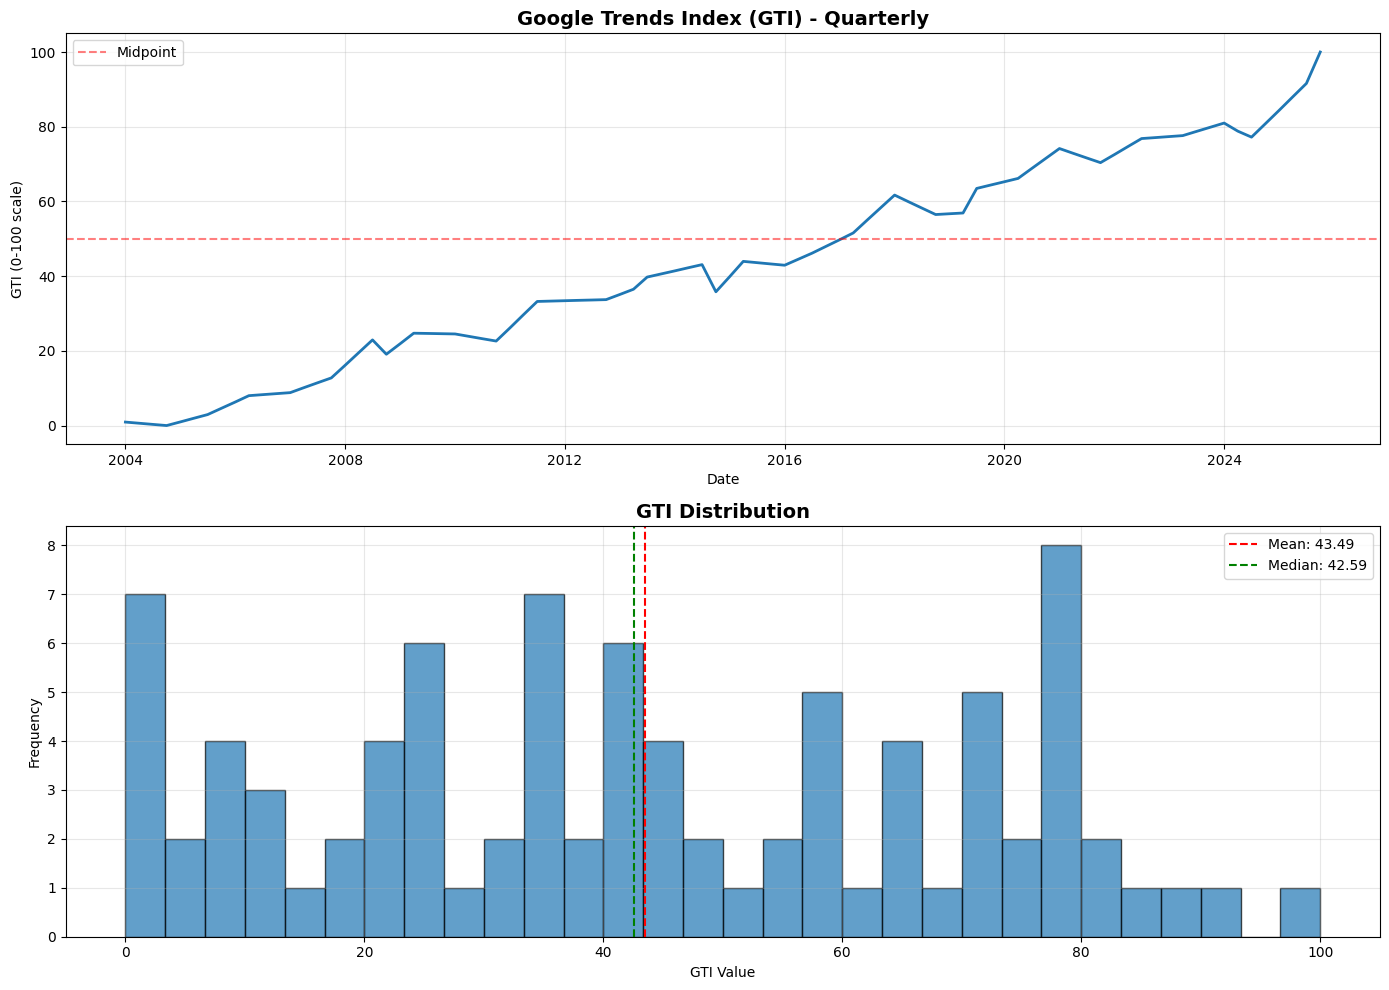

Visualization complete.


In [ ]:
"""Optional: GTI time series visualization.

Generate diagnostic plots to assess GTI characteristics and temporal
patterns. Useful for quality assurance and identifying anomalies.
"""

import matplotlib.pyplot as plt

# Create figure with subplots.
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: GTI time series.
axes[0].plot(pd.to_datetime(gti_output['date']), gti_output['GTI'], linewidth=2)
axes[0].set_title('Google Trends Index (GTI) - Quarterly', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('GTI (0-100 scale)')
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=50, color='r', linestyle='--', alpha=0.5, label='Midpoint')
axes[0].legend()

# Plot 2: GTI distribution histogram.
axes[1].hist(gti_output['GTI'], bins=30, edgecolor='black', alpha=0.7)
axes[1].set_title('GTI Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('GTI Value')
axes[1].set_ylabel('Frequency')
axes[1].axvline(x=gti_output['GTI'].mean(), color='r', linestyle='--',
                label=f"Mean: {gti_output['GTI'].mean():.2f}")
axes[1].axvline(x=gti_output['GTI'].median(), color='g', linestyle='--',
                label=f"Median: {gti_output['GTI'].median():.2f}")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Visualization complete.")


In [ ]:
"""Optional: Export diagnostic statistics.

Calculate and export comprehensive statistics about the GTI for
documentation and validation purposes.
"""

# Calculate summary statistics.
stats = {
    'Metric': [
        'Count',
        'Mean',
        'Std Dev',
        'Min',
        '25th Percentile',
        'Median',
        '75th Percentile',
        'Max',
        'Range',
        'Start Date',
        'End Date',
    ],
    'Value': [
        len(gti_output),
        f"{gti_output['GTI'].mean():.2f}",
        f"{gti_output['GTI'].std():.2f}",
        f"{gti_output['GTI'].min():.2f}",
        f"{gti_output['GTI'].quantile(0.25):.2f}",
        f"{gti_output['GTI'].median():.2f}",
        f"{gti_output['GTI'].quantile(0.75):.2f}",
        f"{gti_output['GTI'].max():.2f}",
        f"{gti_output['GTI'].max() - gti_output['GTI'].min():.2f}",
        gti_output['date'].iloc[0],
        gti_output['date'].iloc[-1],
    ]
}

stats_df = pd.DataFrame(stats)

print("GTI Summary Statistics:")
print("=" * 50)
display(stats_df)

# Optionally export to Excel.
stats_filename = "GTI_Summary_Statistics.xlsx"
stats_df.to_excel(stats_filename, index=False)
print(f"\nStatistics exported to: {stats_filename}")


GTI Summary Statistics:


,Metric,Value
0,Count,88
1,Mean,43.49
2,Std Dev,26.68
3,Min,0.00
4,25th Percentile,23.17
5,Median,42.59
6,75th Percentile,66.82
7,Max,100.00
8,Range,100.00
9,Start Date,2004-01-01



Statistics exported to: GTI_Summary_Statistics.xlsx
